In [1]:
#%%
"""
Adapted from Zongyi Li TODO: include referene in the README
This file is the Fourier Neural Operator for 3D problem takes the 2D spatial + 1D temporal equation directly as a 3D problem
"""
# %%
import sys
sys.path.append("..")
import os
import torch.nn.functional as F
from utilities import *
from timeit import default_timer
import matplotlib.pyplot as plt
import numpy as np
import resource
from model_fourier_3d import *
import torch
print(torch.__version__)
print(f"GPUs:{torch.cuda.device_count()}")
import os
print(os.getcwd())

/samoa/data/smrserraoseabr/.conda_samoa/envs/NN/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.0+cu117
GPUs:2
/samoa/data/smrserraoseabr/NO-DA/dataprocessing


In [2]:
import os
import shutil
import pandas as pd
import xarray as xr
import numpy as np

# Define directory
dir_path = '/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS/runnedmodels_wells/filtered'

# Initialize DataFrame
df = pd.DataFrame(columns=['File', 'Contains NaN'])

# Walk through files
for root, dirs, files in os.walk(dir_path):
    for file in files:
        if file.endswith(".nc"):
            file_path = os.path.join(root, file)
            data = xr.open_dataset(file_path)
            
            # Check for NaN values
            if data.isnull().any():
                # Create a record
                df.loc[len(df)] = [file_path, True]
                
                # Move the file
                parent_folder = os.path.dirname(root)
                new_path = os.path.join(parent_folder, file)
                shutil.move(file_path, new_path)

# Save DataFrame to a CSV file
df


,File,Contains NaN
0,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,True
1,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,True
2,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,True
3,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,True
4,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,True
...,...,...
947,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,True
948,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,True
949,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,True
950,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,True


In [6]:
import os
import pandas as pd
import xarray as xr
import shutil

# Define directory
dir_path = '/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS/runnedmodels_wells'

# Initialize a DataFrame to store NaN counts
df = pd.DataFrame(columns=['File', 'Variable', 'NaN Count'])

# Walk through files
for root, dirs, files in os.walk(dir_path):
    for file in files:
        if file.endswith(".nc"):
            file_path = os.path.join(root, file)

            # Open the dataset
            data = xr.open_dataset(file_path)

            # Track whether this file contains any NaN values
            has_nan = False

            # Iterate over all data variables
            for var in data.data_vars:
                # Calculate the number of NaN values in this variable
                num_nan = data[var].isnull().sum().values.item()

                # Add the information to the DataFrame
                df.loc[len(df)] = [file_path, var, num_nan]

                # If we found any NaN values, remember that this file contains NaN
                if num_nan > 0:
                    has_nan = True

            # If this file does not contain any NaN values, move it to the 'filtered' subdirectory
            if not has_nan:
                filtered_dir = os.path.join(root, 'filtered')
                os.makedirs(filtered_dir, exist_ok=True)
                shutil.move(file_path, os.path.join(filtered_dir, file))

# Save DataFrame to a CSV file for later use
df


,File,Variable,NaN Count
0,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,FIPS_c_2,0
1,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,BHP,0
2,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,p_0_reservoir_P,0
3,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,p_0_c_1_rate,0
4,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,p_0_c_2_rate,0
...,...,...,...
22052,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,H2O,0
22053,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,Perm,0
22054,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,Por,0
22055,/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS...,i,0


In [7]:
import os
import pandas as pd
import xarray as xr
import shutil

# Define directory
dir_path = '/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS/runnedmodels'

# Initialize a DataFrame to store NaN counts
df = pd.DataFrame(columns=['File', 'Variable', 'NaN Count'])
# Now, go through all 'filtered' directories and verify that no NaN values are found in the moved .nc files
for root, dirs, files in os.walk(dir_path):
    if os.path.basename(root) == 'filtered':
        for file in files:
            if file.endswith(".nc"):
                file_path = os.path.join(root, file)

                # Open the dataset
                data = xr.open_dataset(file_path)

                # Iterate over all data variables
                for var in data.data_vars:
                    # Calculate the number of NaN values in this variable
                    num_nan = data[var].isnull().sum().values.item()

                    # If we found any NaN values, print a warning
                    if num_nan > 0:
                        print(f'Warning: found {num_nan} NaN values in variable {var} in file {file_path} in the filtered directory.')

In [2]:
tag = 'Test' 
folder =  "/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS/runnedmodels_wells/filtered"  #  "/nethome/atena_projetos/bgy3/NO-DA/datasets/results" + str(resolution) + "/"
input_vars = ['Por', 'Perm', 'gas_rate'] # Porosity, Permeability, ,  Well 'gas_rate', Pressure + x, y, time encodings 
output_vars = ['Pressure'] 
num_files= 1000
traintest_split = 0.8
batch_size = 1000
normalizer = 'MinMax'
ntrain = num_files*traintest_split
ntest = num_files - ntrain
device = 'cpu'
dataset = ReadXarrayDataset(folder=folder, input_vars=input_vars, output_vars=output_vars, num_files = num_files, wells_positions=False)

train_size = int(traintest_split * len(dataset))
test_size = len(dataset) - train_size


train_loader = DataLoader(torch.utils.data.Subset(dataset, range(0, train_size)),
                           batch_size=batch_size,
                             shuffle=False)
test_loader = DataLoader(torch.utils.data.Subset(dataset, range(train_size, train_size + test_size)), 
                         batch_size=batch_size, 
                         shuffle=False)

###DEBUG NORMALIZATION

In [2]:
import torch.nn.functional as F
from utilities import *
from timeit import default_timer
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

/home/smrserraoseabr/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

class PointGaussianNormalizer(object):
    def __init__(self, dataloader, is_label=False, eps=0.00001):
        super(PointGaussianNormalizer, self).__init__()
        self.eps = eps
        self.mean, self.std = self.batch_mean_and_sd(dataloader, is_label)

    def batch_mean_and_sd(self, loader, is_label):
        cnt = 0
        fst_moment = None
        snd_moment = None

        for data, labels in loader:
            data = labels if is_label else data  # if this is label normalizer, normalize labels
            data_shape = data.shape[-1]
            if fst_moment is None:
                fst_moment = torch.zeros(data_shape)
                snd_moment = torch.zeros(data_shape)

            b, t, h, w, c = data.shape
            nb_pixels = b * t * h * w
            sum_ = torch.sum(data, dim=[0, 1, 2, 3])
            sum_of_square = torch.sum(data ** 2, dim=[0, 1, 2, 3])
            fst_moment += sum_
            snd_moment += sum_of_square
            cnt += nb_pixels

        fst_moment /= cnt
        snd_moment /= cnt

        return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return x * (self.std + self.eps) + self.mean

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


In [4]:
# Generate some sample data
data = torch.randn(100, 61, 32, 32, 6)*2000
labels = torch.randn(100, 61, 32, 32, 1)*3000

# Create dataloader

dataset = TensorDataset(data, labels)
subset = torch.utils.data.Subset(dataset, range(0, 100))
dataloader = DataLoader(dataset, batch_size=10)

# Create normalizers
input_normalizer = PointGaussianNormalizer(dataloader, is_label=False)
label_normalizer = PointGaussianNormalizer(dataloader, is_label=True)

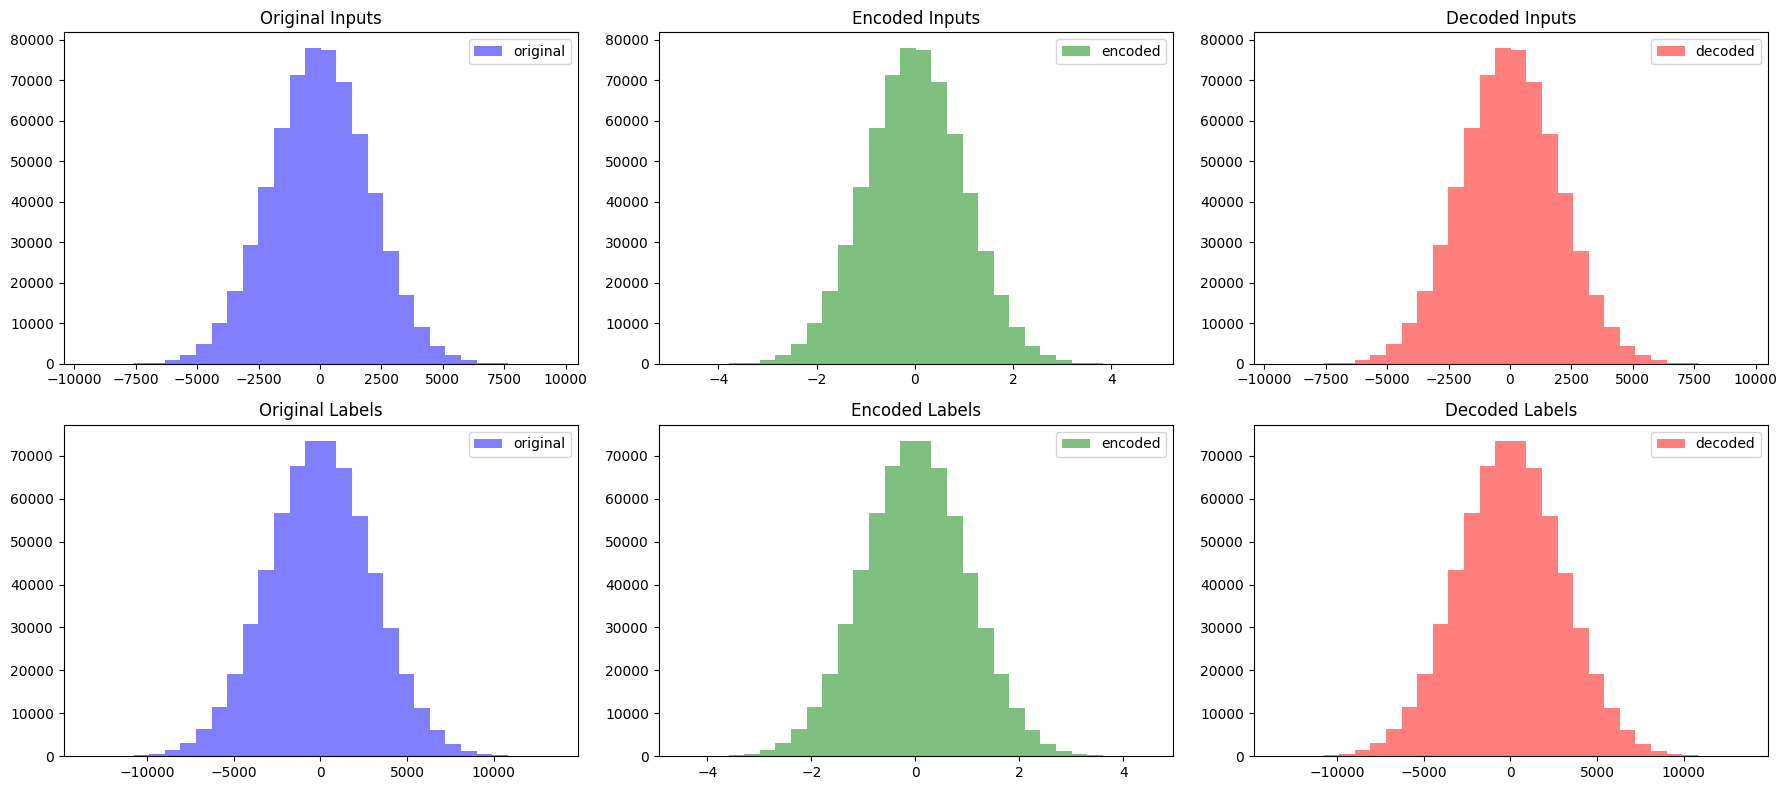

In [5]:
import matplotlib.pyplot as plt

# Pick the first batch of data
inputs, labels = next(iter(dataloader))

# Normalize inputs and labels
normalized_inputs = input_normalizer.encode(inputs)
normalized_labels = label_normalizer.encode(labels)

# Decode the normalized inputs and labels
decoded_inputs = input_normalizer.decode(normalized_inputs)
decoded_labels = label_normalizer.decode(normalized_labels)

# Pick a feature index to plot (any integer from 0 to 5 for your case)
feature_idx = 0

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

# Plot original inputs
axes[0, 0].hist(inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='b', label='original')
axes[0, 0].set_title('Original Inputs')

# Plot encoded inputs
axes[0, 1].hist(normalized_inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='g', label='encoded')
axes[0, 1].set_title('Encoded Inputs')

# Plot decoded inputs
axes[0, 2].hist(decoded_inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='r', label='decoded')
axes[0, 2].set_title('Decoded Inputs')

# Plot original labels
axes[1, 0].hist(labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='b', label='original')
axes[1, 0].set_title('Original Labels')

# Plot encoded labels
axes[1, 1].hist(normalized_labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='g', label='encoded')
axes[1, 1].set_title('Encoded Labels')

# Plot decoded labels
axes[1, 2].hist(decoded_labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='r', label='decoded')
axes[1, 2].set_title('Decoded Labels')

for ax_row in axes:
    for ax in ax_row:
        ax.legend()

plt.tight_layout()
plt.show()


In [5]:
# %%
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from utilities import *
import imageio
from io import BytesIO
from IPython.display import Image as DisplayImage
from model_fourier_3d import *
import torchmetrics
print(torch.__version__)
print(f"GPUs:{torch.cuda.device_count()}")
import os



1.13.0+cu117
GPUs:2


In [6]:
#read the data of the new and old data
class PointMinMaxNormalizer(object):
    def __init__(self, dataloader, min_val=None, max_val=None, is_label=False):
        super(PointMinMaxNormalizer, self).__init__()
        if min_val is None or max_val is None:
            self.min_val, self.max_val = self.batch_min_and_max(dataloader, is_label)
        else:
            self.min_val = min_val
            self.max_val = max_val

    def batch_min_and_max(self, loader, is_label):
        min_val = None
        max_val = None

        for data, labels in loader:
            data = labels if is_label else data  # if this is label normalizer, normalize labels
            data_shape = data.shape[-1]
            if min_val is None:
                min_val = torch.zeros(data_shape)
                max_val = torch.zeros(data_shape)

            b, t, h, w, c = data.shape
            data = data.view(b * t * h * w, c)
            batch_min = torch.min(data, dim=0)[0]
            batch_max = torch.max(data, dim=0)[0]
            min_val = torch.min(min_val, batch_min)
            max_val = torch.max(max_val, batch_max)

        return min_val, max_val

    def encode(self, x):
        return (x - self.min_val) / (self.max_val - self.min_val)

    def decode(self, x):
        return x * (self.max_val - self.min_val) + self.min_val

    def cuda(self, device):
        self.min_val = self.min_val.to(device)
        self.max_val = self.max_val.to(device)
        return self


In [7]:
new_data_folder = '/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS/runnedmodels/filtered'

input_vars = ['Por', 'Perm', 'gas_rate'] # Porosity, Permeability, ,  Well 'gas_rate', Pressure + x, y, time encodings 
output_vars = ['Pressure'] 
num_files= 1000
traintest_split = 0.8
batch_size = 1

ntrain = num_files*traintest_split
ntest = num_files - ntrain


device = 'cpu' 

#NEW
dataset_new = ReadXarrayDataset(folder=new_data_folder, input_vars=input_vars, output_vars=output_vars, num_files = num_files, wells_positions=False)
train_size = int(traintest_split * len(dataset_new))
test_size = len(dataset_new) - train_size
train_loader_new = DataLoader(torch.utils.data.Subset(dataset_new, range(0, train_size)),
                              batch_size=batch_size,
                                shuffle=False)
input_normalizer_new = PointMinMaxNormalizer(train_loader_new, is_label=False)
output_normalizer_new = PointMinMaxNormalizer(train_loader_new, is_label=True)

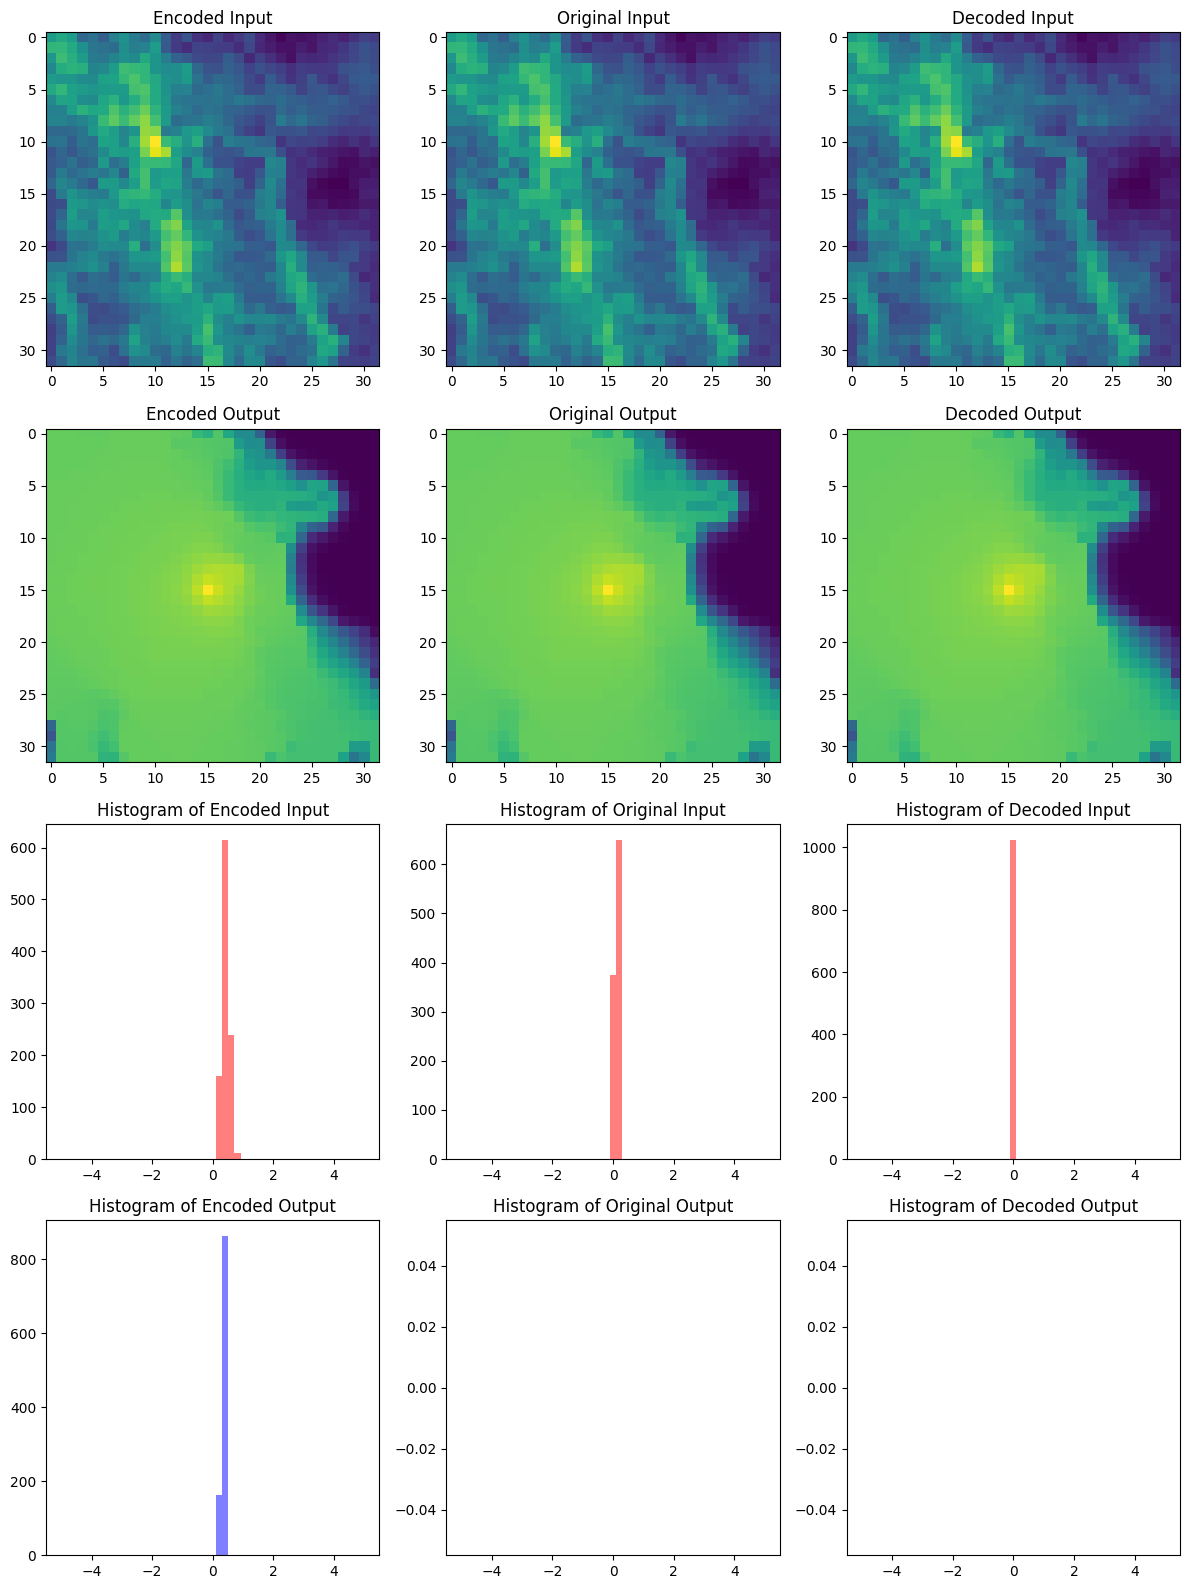

In [13]:
import numpy as np
import matplotlib.pyplot as plt

for index, (x, y) in enumerate(train_loader_new):
    x = x.to(device)
    y = y.to(device)

    x_encoded = input_normalizer_new.encode(x)
    y_encoded = output_normalizer_new.encode(y)
    y_decoded = output_normalizer_new.decode(y)
    x_decoded = input_normalizer_new.decode(x)

    if index == 0:
        fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 16)) # Adjusted the number of rows

        # Plot images
        ax[0, 0].imshow(x_encoded[0, -1, :, :, 0].T)
        ax[0, 0].set_title('Encoded Input')

        ax[0, 1].imshow(x[0, -1, :, :, 0].T)
        ax[0, 1].set_title('Original Input')

        ax[0, 2].imshow(x_decoded[0, -1, :, :, 0].T)
        ax[0, 2].set_title('Decoded Input')

        ax[1, 0].imshow(y_encoded[0, -1, :, :, 0].T)
        ax[1, 0].set_title('Encoded Output')

        ax[1, 1].imshow(y[0, -1, :, :, 0].T)
        ax[1, 1].set_title('Original Output')

        ax[1, 2].imshow(y_decoded[0, -1, :, :, 0].T)
        ax[1, 2].set_title('Decoded Output')


        bins = np.linspace(-5, 5, 50)

        # Plot histograms
        ax[2, 0].hist(x_encoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='red')
        ax[2, 0].set_title('Histogram of Encoded Input')

        ax[2, 1].hist(x[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='red')
        ax[2, 1].set_title('Histogram of Original Input')

        ax[2, 2].hist(x_decoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='red')
        ax[2, 2].set_title('Histogram of Decoded Input')

        ax[3, 0].hist(y_encoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='blue')
        ax[3, 0].set_title('Histogram of Encoded Output')

        ax[3, 1].hist(y[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='blue')
        ax[3, 1].set_title('Histogram of Original Output')

        ax[3, 2].hist(y_decoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='blue')
        ax[3, 2].set_title('Histogram of Decoded Output')

        plt.tight_layout()
        plt.show()

        break


In [12]:
y[0, -1, :, :, 0].flatten()


tensor([243.3559, 243.3594, 243.3514,  ..., 228.0526, 218.8632, 206.1882])

In [10]:
for index, (x, y) in enumerate(train_loader_new):
    x = x.to(device)
    y = y.to(device)

    # Assuming you have test_input_normalizer and test_output_normalizer objects

    x_encoded = input_normalizer_new.encode(x)
    y_encoded = output_normalizer_new.encode(y)
    y_decoded = output_normalizer_new.decode(y)
    x_decoded = input_normalizer_new.decode(x)
    

    # Compare the original and decoded data
    x_diff = torch.abs(x - x_decoded)
    y_diff = torch.abs(y - y_decoded)


    x_mae = torch.mean(x_diff)
    y_mae = torch.mean(y_diff)

    # Print the MAE values
    print("Input MAE:", x_mae.item())
    print("Output MAE:", y_mae.item())

    x_mse = torch.mean(x_diff**2)
    y_mse = torch.mean(y_diff**2)
    x_psnr = 10 * torch.log10(1.0 / x_mse)
    y_psnr = 10 * torch.log10(1.0 / y_mse)

    # Print the PSNR values - PSNR is the peak signal-to-noise ratio which is a measure of the quality of reconstruction
    print("Input PSNR:", x_psnr.item())
    print("Output PSNR:", y_psnr.item())


    # Define tolerance values
    x_tol = 1e-5  # Adjust the tolerance value as needed
    y_tol = 1e-5  # Adjust the tolerance value as needed

    # Check if the decoding is accurate
    if torch.allclose(x, x_decoded, atol=x_tol, rtol=0):
        print("Input decoding is accurate!")
    else:
        print("Input decoding is not accurate.")

    if torch.allclose(y, y_decoded, atol=y_tol, rtol=0):
        print("Output decoding is accurate!")
    else:
        print("Output decoding is not accurate.")


Input MAE: 878692.375
Output MAE: 144545.734375
Input PSNR: -121.88045501708984
Output PSNR: -103.20545959472656
Input decoding is not accurate.
Output decoding is not accurate.
Input MAE: 835241.875
Output MAE: 143735.921875
Input PSNR: -121.60931396484375
Output PSNR: -103.15853118896484
Input decoding is not accurate.
Output decoding is not accurate.
Input MAE: 985232.4375
Output MAE: 151528.921875
Input PSNR: -122.73352813720703
Output PSNR: -103.62432861328125
Input decoding is not accurate.
Output decoding is not accurate.
Input MAE: 799107.6875
Output MAE: 142823.609375
Input PSNR: -121.42991638183594
Output PSNR: -103.10285949707031
Input decoding is not accurate.
Output decoding is not accurate.
Input MAE: 1094147.5
Output MAE: 155984.53125
Input PSNR: -123.75457763671875
Output PSNR: -103.90171813964844
Input decoding is not accurate.
Output decoding is not accurate.
Input MAE: 916813.1875
Output MAE: 146109.625
Input PSNR: -122.159912109375
Output PSNR: -103.30130767822266
I

In [3]:
#TEST THE INCLUSION OF WELLS POSITION
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, IterableDataset, TensorDataset
import os
import xarray as xr

import scipy.io
import h5py


import operator
from functools import reduce
from functools import partial

#################################################
#
# Custom Dataset Class
#
#################################################

class ReadXarrayDataset(Dataset):
    def __init__(self, folder, input_vars, output_vars, num_files=None):
        self.folder = folder        
        self.file_list = os.listdir(folder)[:num_files] if num_files else os.listdir(folder)            
        self.input_vars = input_vars.copy()
        self.input_vars.append('x_encoding')
        self.input_vars.append('y_encoding')
        self.input_vars.append('time_encoding')
        self.output_vars = output_vars.copy()

        # self.input_normalizers = []
        # self.output_normalizers = []
        # self.file_stats = {}
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder, self.file_list[idx])
        data = xr.open_dataset(file_path)

        X = data['X'].values
        Y = data['Y'].values
        TIME = data['time'].values

        x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
        TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
        data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))
        
        input_data = []
        for var in self.input_vars:
            if 'time' in data[var].dims and 'X' in data[var].dims and 'Y' in data[var].dims:
                input_data.append(torch.tensor(data[var].values, dtype=torch.float32))
            elif 'X' in data[var].dims and 'Y' in data[var].dims:
                scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32) 
                scalar_matrix = scalar_matrix.unsqueeze(0).expand(data.time.size, -1, -1)
                input_data.append(scalar_matrix)
            elif 'time' in data[var].dims:
                variable_matrix = torch.zeros((data.time.size, data.X.size, data.Y.size), dtype=torch.float32)
                for origin in data.origin.values:
                    i, j = data.sel(origin=origin)[['i', 'j']].values
                    variable_matrix[:, i, j] = torch.tensor(data.sel(origin=origin)[var].values, dtype=torch.float32)           

                input_data.append(scalar_matrix)
                
        #print(len(input_data))

        output_data = []
        for var in self.output_vars:
           output_data.append(torch.tensor(data[var].values, dtype=torch.float32))

        #print(output_data)


        input_data = torch.stack(input_data, dim=-1)
        output_data = torch.stack(output_data, dim=-1)
    
        return input_data, output_data 

In [9]:
file_path = '/scratch/smrserraoseabr/Projects/NO-DA/dataset/test/darts_result_geomodel_1.nc'
input_vars = ['Por', 'Perm', 'gas_rate'] # Porosity, Permeability, ,  Well 'gas_rate', Pressure + x, y, time encodings 
output_vars = ['Pressure'] 



In [11]:
import xarray as xr
import torch
import numpy as np
import os

def read_xarray_dataset(file_path, input_vars, output_vars):
    data = xr.open_dataset(file_path)

    X = data['X'].values
    Y = data['Y'].values
    TIME = data['time'].values

    x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
    TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
    data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
    data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
    data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))

    input_data = []
    for var in input_vars:
        if 'time' in data[var].dims and 'X' in data[var].dims and 'Y' in data[var].dims:
            input_data.append(torch.tensor(data[var].values, dtype=torch.float32))
        elif 'X' in data[var].dims and 'Y' in data[var].dims:
            scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32)
            scalar_matrix = scalar_matrix.unsqueeze(0).expand(data.time.size, -1, -1)
            input_data.append(scalar_matrix)
        elif 'time' in data[var].dims:
            variable_matrix = torch.zeros((data.time.size, data.X.size, data.Y.size), dtype=torch.float32)
            for origin in data.origin.values:
                i = data.sel(origin=origin)['i'].values.item()
                j = data.sel(origin=origin)['j'].values.item()
                variable_matrix[:, i, j] = torch.tensor(data.sel(origin=origin)[var].values, dtype=torch.float32)           

            input_data.append(variable_matrix)

    output_data = []
    for var in output_vars:
        output_data.append(torch.tensor(data[var].values, dtype=torch.float32))

    input_data = torch.stack(input_data, dim=-1)
    output_data = torch.stack(output_data, dim=-1)

    return input_data, output_data


# Test the function

input_data, output_data = read_xarray_dataset(file_path, input_vars, output_vars)

print("Input data shape:", input_data.shape)
print("Output data shape:", output_data.shape)


Input data shape: torch.Size([61, 32, 32, 3])
Output data shape: torch.Size([61, 32, 32, 1])


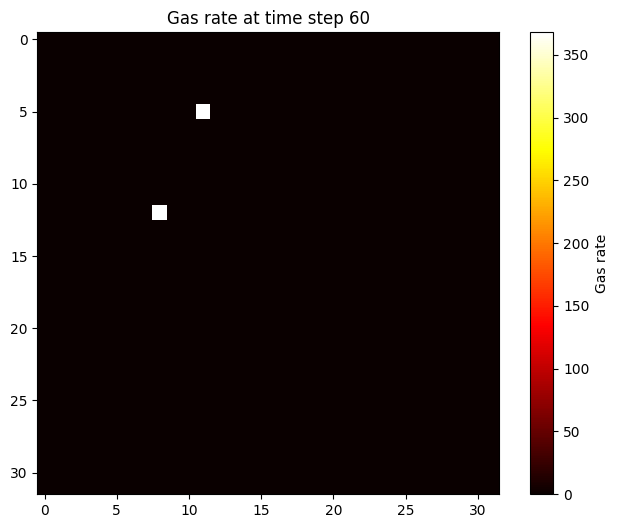

In [15]:
import matplotlib.pyplot as plt

# Assume time_step is the time step you want to visualize
time_step = 60
# Get the 'gas_rate' from input_data (it's the third variable, index 2)
gas_rate = input_data[time_step, :, :, 2]

# Plotting
plt.figure(figsize=(8,6))
plt.imshow(gas_rate, cmap='hot', interpolation='nearest')
plt.colorbar(label='Gas rate')
plt.title(f'Gas rate at time step {time_step}')
plt.show()


In [1]:
import os
import shutil
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#load a single xarray file from new and one single fro old dataet 
old_dir = '/samoa/data/smrserraoseabr/NO-DA/dataset/mixedcontext32x32/'
new_dir = '/samoa/data/smrserraoseabr/NO-DA/dataset/DARTS/runnedmodels/filtered'
# List of properties to compare
properties = ['Por', 'Perm', 'Pressure', 'CO_2', 'gas_rate']

# Function to load datasets and calculate statistics
def calculate_statistics(directory, properties):
    # Get list of all .nc files in the directory
    files = [f for f in os.listdir(directory) if f.endswith('.nc')]
    
    values = {prop: [] for prop in properties}
    files_with_issues = {prop: [] for prop in properties}
    
    # Load each dataset, calculate statistics and store in list
    for file in files:
        ds = xr.open_dataset(os.path.join(directory, file))
        for prop in properties:
            if prop in ds.data_vars:
                df = ds[prop].to_dataframe()
                val_list = df.values.flatten().tolist()
                values[prop].extend(val_list)
                if any(v < 0 for v in val_list) or np.isnan(val_list).any():
                    files_with_issues[prop].append(file)
    
    # Calculate overall statistics
    stats = {prop: pd.Series(values[prop]).describe() for prop in properties}
    
    return stats, files_with_issues

# Calculate statistics for old and new datasets
old_stats, old_issues = calculate_statistics(old_dir, properties)
new_stats, new_issues = calculate_statistics(new_dir, properties)

# Compare statistics
for prop in properties:
    print(f"Statistics for {prop}:")
    print("Old:")
    print(old_stats[prop])
    print("Files with negative or NaN values: ", old_issues[prop])
    print("New:")
    print(new_stats[prop])
    print("Files with negative or NaN values: ", new_issues[prop])
    print("\n")

# Plotting
for prop in properties:
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))

    old_stats[prop].plot(kind='box', ax=ax[0])
    ax[0].set_title(f'Old {prop}')

    new_stats[prop].plot(kind='box', ax=ax[1])
    ax[1].set_title(f'New {prop}')

    plt.tight_layout()
    plt.show()


NameError: name 'os' is not defined